In [1]:
%load_ext autoreload

In [289]:
%autoreload 2
from datetime import datetime
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
import numpy as np
import os
import pandas as pd
import re
import scipy
from scipy.signal import butter, lfilter
from statsmodels.tsa.api import VAR
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

sys.path.append('../../..')
from multiproc import compute_VAR
from multiproc_VAR_p_grid_search import compute_VAR_p, predict_VAR_p
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

# Load Neural Data 

In [3]:
session = 'Mary-Anesthesia-20160912-02'

In [4]:
all_data_dir = '/om/user/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [5]:
variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['unitInfo']

In [6]:
spike_times = spike_times[0]

# Time Shifted Surrogates

In [7]:
area = 'vlPFC'
if area == 'all':
    area_indices = np.arange(len(electrode_info['area']))
else:
    area_indices = np.where(electrode_info['area'] == area)[0]

In [11]:
window_start = 30*60 # s
window_length = 8 # s
window_start_ind = int(window_start/dt)
window_end_ind = window_start_ind + int(window_length/dt)
signal = lfp[window_start_ind:window_end_ind, area_indices]

In [64]:
time_shift_sigma = 0.5 # s
time_shift_sigma = int(time_shift_sigma/dt) # ms
time_shifts = np.int0(np.round(np.random.normal(loc=0, scale=time_shift_sigma, size=(signal.shape[1],))))
shifted_signal = np.zeros(signal.shape)
for i in range(shifted_signal.shape[1]):
    shifted_signal[:, i] = lfp[window_start_ind + time_shifts[i]:window_end_ind + time_shifts[i], area_indices[i]]

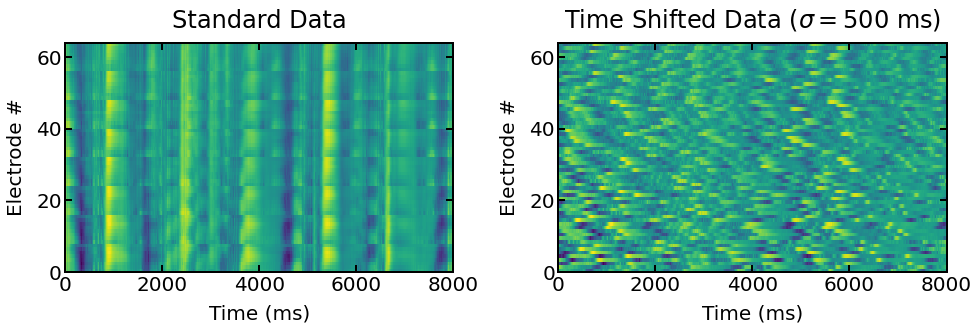

In [65]:
plt.style.use('../../sci_style.py')
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.pcolormesh(signal.T)
plt.xlabel('Time (ms)')
plt.ylabel('Electrode #')
plt.title('Standard Data')
plt.subplot(1, 2, 2)
plt.pcolormesh(shifted_signal.T)
plt.xlabel('Time (ms)')
plt.ylabel('Electrode #')
plt.title(r'Time Shifted Data ($\sigma = $' + f'{time_shift_sigma} ms)')
plt.tight_layout()
plt.show()

In [66]:
standard_results = compute_VAR(signal)
shifted_results = compute_VAR(shifted_signal)

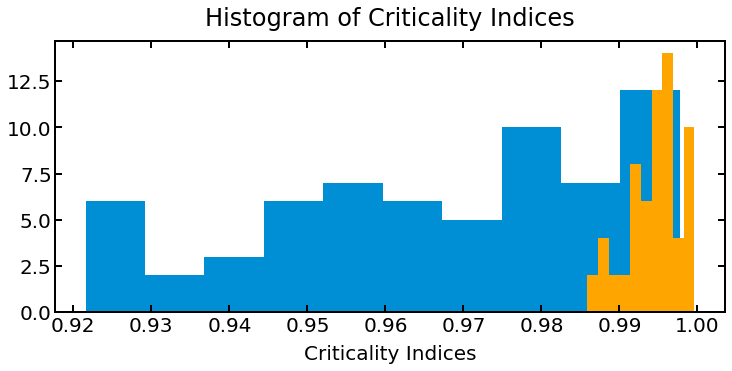

In [67]:
plt.subplots(figsize=(12, 5))
plt.hist(standard_results['criticality_inds'], density=False, label='standard')
plt.hist(shifted_results['criticality_inds'], color='orange', density=False, label='shifted')
plt.xlabel('Criticality Indices')
plt.title('Histogram of Criticality Indices')
plt.show()

# Setting Up Big Signals

In [296]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [318]:
area = 'vlPFC'
if area == 'all':
    area_indices = np.arange(len(electrode_info['area']))
else:
    area_indices = np.where(electrode_info['area'] == area)[0]

big_window_start = 30*60 # s
big_window_length = 100 # s
big_window_start_ind = int(big_window_start/dt)
big_window_end_ind = big_window_start_ind + int(big_window_length/dt)
big_signal = lfp[big_window_start_ind:big_window_end_ind, area_indices]

In [319]:
low = 1
high = 80
for i in range(big_signal.shape[1]):
    big_signal[:, i] = butter_bandpass_filter(big_signal[:, i], low, high, 1/dt)

In [320]:
time_shift_sigma = 10 # s
time_shift_sigma = int(time_shift_sigma/dt) # ms
time_shifts = np.int0(np.round(np.random.normal(loc=0, scale=time_shift_sigma, size=(signal.shape[1],))))
big_shifted_signal = np.zeros(big_signal.shape)
for i in range(shifted_signal.shape[1]):
    big_shifted_signal[:, i] = lfp[big_window_start_ind + time_shifts[i]:big_window_end_ind + time_shifts[i], area_indices[i]]

In [321]:
for i in range(big_signal.shape[1]):
    big_shifted_signal[:, i] = butter_bandpass_filter(big_shifted_signal[:,i], low, high, 1/dt)

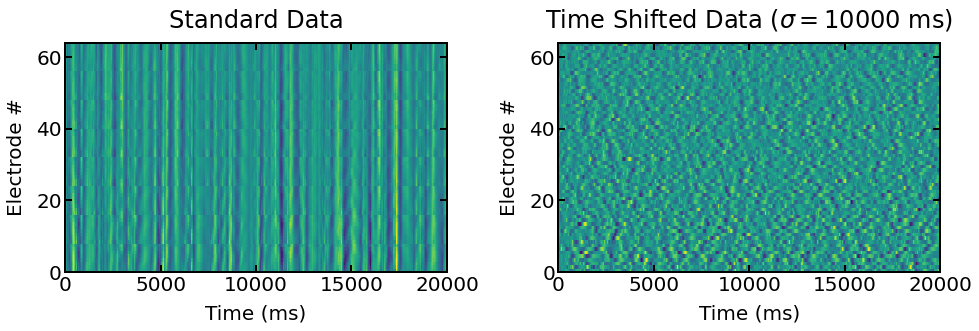

In [322]:
plt.style.use('../../sci_style.py')
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.pcolormesh(big_signal[:20000].T)
plt.xlabel('Time (ms)')
plt.ylabel('Electrode #')
plt.title('Standard Data')
plt.subplot(1, 2, 2)
plt.pcolormesh(big_shifted_signal[:20000].T)
plt.xlabel('Time (ms)')
plt.ylabel('Electrode #')
plt.title(r'Time Shifted Data ($\sigma = $' + f'{time_shift_sigma} ms)')
plt.tight_layout()
plt.show()

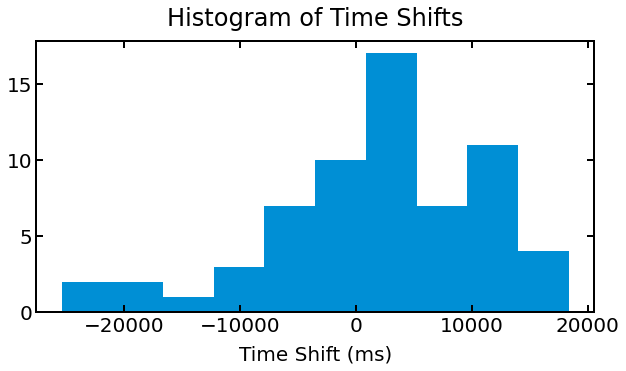

In [294]:
plt.hist(time_shifts)
plt.xlabel('Time Shift (ms)')
plt.title("Histogram of Time Shifts")
plt.show()

# VAR Grid Search - Standard

In [323]:
d = 10
indices = np.random.choice(np.arange(big_signal.shape[1]), size=(d, ), replace=False)

In [336]:
# data = big_signal[:,  indices]
data = big_shifted_signal[:,  indices]

In [337]:
windows = [int(w) if w % 1 == 0 else w for w in np.arange(0.5, 10.1, 0.5)]
# windows = np.hstack([np.arange(0.05, 0.101, 0.01), [0.25, 0.5, 0.75, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]])
# windows = [0.25, 0.5, 0.75, 1, 2, 3, 4, 5]
max_lag = 15
lags = np.arange(1, max_lag + 1)
T_pred = 25
num_window_samples = 10

In [338]:
grid_search_df = []
iterator = tqdm(total = len(windows)*len(lags))
for window in windows:
    stride = window
    min_ind = int(0/stride)
    max_ind = int((data.shape[0]*dt - window - T_pred*dt)/stride)
    possible_inds = np.arange(min_ind, max_ind + 1)
    window_inds = np.random.choice(possible_inds, size=(np.min([num_window_samples, len(possible_inds)])), replace=False)
#     num_windows = int(np.floor((data.shape[0]-window)/stride)+1)
    for p in lags:
#         for i in range(num_windows):
        for i in window_inds:
            start_ind = i*int(stride/dt)
            start_time = i*stride
            end_ind = i*int(stride/dt) + int(window/dt)
            end_time = i*stride + window
            if end_ind + T_pred <= data.shape[0]:
                
                window_data = data[start_ind:end_ind]
                results = compute_VAR_p(window_data, p)
                test_data = data[end_ind - p:end_ind + T_pred]

                train_prediction, train_true_vals = predict_VAR_p(window_data, results['coefs'], results['intercept'])
                train_mse = ((train_prediction - train_true_vals)**2).mean()
                test_prediction, test_true_vals = predict_VAR_p(test_data, results['coefs'], results['intercept'])
#                 print(test_prediction.shape)
                test_mse = ((test_prediction - test_true_vals)**2).mean()
                persistence_baseline = ((data[end_ind:end_ind + T_pred] - data[end_ind - 1:end_ind + T_pred -1])**2).mean()

                # ADD TO DICTIONARY
                results['train_mse'] = train_mse
                results['test_mse'] = test_mse
                results['persistence_baseline'] = persistence_baseline

                # ADD TIMESTAMPS
                results['start_ind'] = start_ind
                results['end_ind'] = end_ind
                results['start_time'] = start_time
                results['end_time'] = end_time

                # ADD PARAMETERS
                results['window'] = window
                results['stride'] = stride
                results['p'] = p
                results['T_pred'] = T_pred
                
                grid_search_df.append(results)
        iterator.update()
iterator.close()
grid_search_df = pd.DataFrame(grid_search_df)

  0%|          | 0/300 [00:00<?, ?it/s]

In [339]:
test_mse_mat = np.zeros((len(windows), len(lags)))
for i, window in enumerate(windows):
    for j, p in enumerate(lags):
        test_mse_mat[i, j] = grid_search_df[np.logical_and(grid_search_df.window == window, grid_search_df.p == p)].test_mse.mean()

In [340]:
def pick_2d_optimum(mat, thresh=0.95):
    true_min = mat.min()
    i_vals, j_vals = np.where(mat*thresh - true_min <= 0)
    selected_i = np.min(i_vals)
    selected_j = np.min(j_vals[i_vals == selected_i])
    selected_i, selected_j

    return selected_i, selected_j
thresh = 1
w_ind, p_ind = pick_2d_optimum(test_mse_mat, thresh)

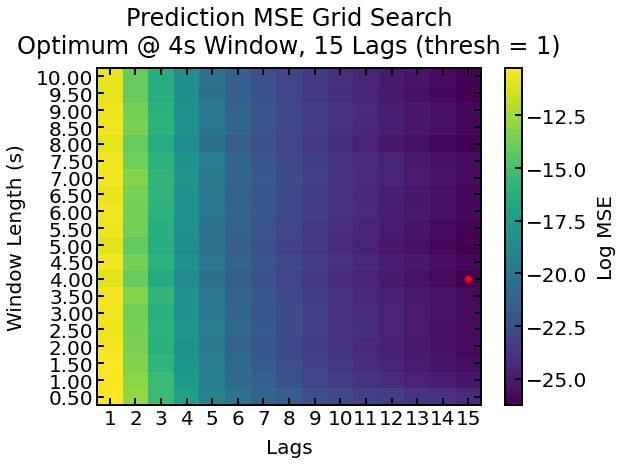

In [341]:
log_test_mse_mat = np.log(test_mse_mat)
plt.style.use('../../sci_style.py')
plt.figure(figsize=(9, 6))
# norm = colors.TwoSlopeNorm(vmin=test_mse_mat.min(), vcenter=test_mse_mat.mean(), vmax=test_mse_mat.max())
# plt.pcolormesh(test_mse_mat, norm=norm)
plt.pcolormesh(log_test_mse_mat)
plt.xticks(np.arange(0, max_lag) + 0.5, [lags[i] for i in np.arange(0, max_lag)])
plt.yticks(np.arange(0, len(windows)) + 0.5, [f"{windows[i]:.2f}" for i in np.arange(0, len(windows))])
plt.xlabel('Lags')
plt.ylabel('Window Length (s)')
cbar = plt.colorbar(label='Log MSE')
# cbar_ticks = [norm.vmin + t*(norm.vcenter-norm.vmin) for t in np.arange(0, 1.1, 0.2)]
# cbar_ticks += [norm.vcenter + t*(norm.vmax-norm.vcenter) for t in np.arange(0, 1.1, 0.2)]
# cbar.set_ticks(cbar_ticks)
plt.scatter([p_ind + 0.5], [w_ind + 0.5], color='red', s=40, label='min')
plt.tight_layout()
plt.title(f"Prediction MSE Grid Search\nOptimum @ {windows[w_ind]}s Window, {lags[p_ind]} Lags (thresh = {thresh})")
plt.show()

# Compute VAR Results

In [342]:
window = windows[w_ind]
p = lags[p_ind]

In [343]:
VAR_results = []
stride = window
num_windows = int(np.floor((data.shape[0]-int(window/dt))/int(stride/dt)+1))
for i in tqdm(range(num_windows)):
    start_ind = i*int(stride/dt)
    start_time = i*stride
    end_ind = i*int(stride/dt) + int(window/dt)
    end_time = i*stride + window
    if end_ind + T_pred <= data.shape[0]:

        window_data = data[start_ind:end_ind]
        results = compute_VAR_p(window_data, p)
        test_data = data[end_ind - p:end_ind + T_pred]

        train_prediction, train_true_vals = predict_VAR_p(window_data, results['coefs'], results['intercept'])
        train_mse = ((train_prediction - train_true_vals)**2).mean()
        test_prediction, test_true_vals = predict_VAR_p(test_data, results['coefs'], results['intercept'])
#                 print(test_prediction.shape)
        test_mse = ((test_prediction - test_true_vals)**2).mean()
        persistence_baseline = ((data[end_ind:end_ind + T_pred] - data[end_ind - 1:end_ind + T_pred -1])**2).mean()

        # ADD TO DICTIONARY
        results['train_mse'] = train_mse
        results['test_mse'] = test_mse
        results['persistence_baseline'] = persistence_baseline

        # ADD TIMESTAMPS
        results['start_ind'] = start_ind
        results['end_ind'] = end_ind
        results['start_time'] = start_time
        results['end_time'] = end_time

        # ADD PARAMETERS
        results['window'] = window
        results['stride'] = stride
        results['p'] = p
        results['T_pred'] = T_pred

        VAR_results.append(results)
VAR_results = pd.DataFrame(VAR_results)

  0%|          | 0/25 [00:00<?, ?it/s]

In [344]:
# VAR_results = grid_search_df[np.logical_and(grid_search_df.window == windows[w_ind], grid_search_df.p == lags[p_ind])]

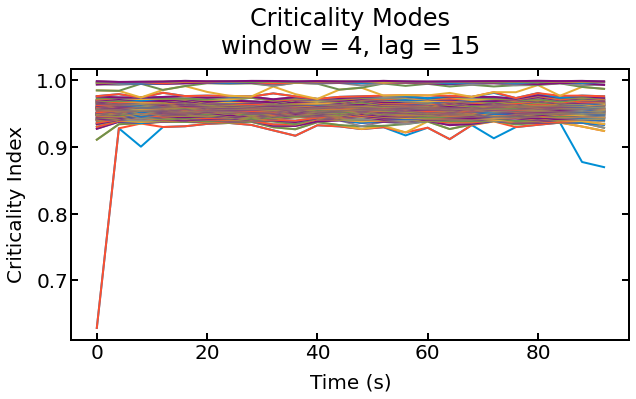

In [345]:
# plot mode criticalities
mode_criticalities = np.zeros((len(VAR_results), len(VAR_results.criticality_inds.iloc[0])))
for i, row in VAR_results.iterrows():
    mode_criticalities[i] = np.sort(row.criticality_inds)

for i in range(len(VAR_results.criticality_inds.iloc[0])):
    plt.plot(VAR_results.start_time, mode_criticalities[:, i])
plt.xlabel('Time (s)')
plt.ylabel('Criticality Index')
plt.title(f"Criticality Modes\nwindow = {window}, lag = {p}")
plt.show()

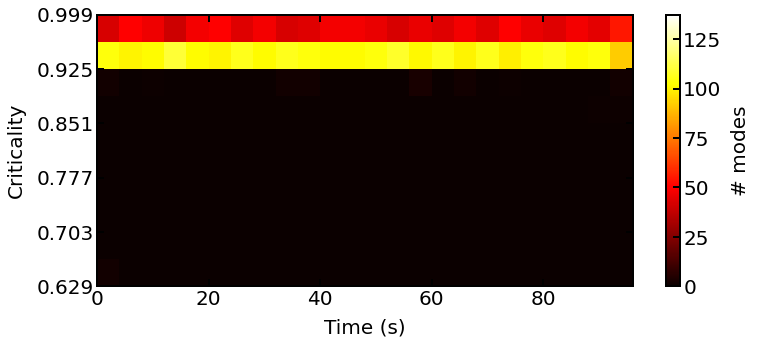

In [346]:
bin_nums = 10
bin_min = np.concatenate(VAR_results.criticality_inds.to_numpy()).min()
bin_max = np.concatenate(VAR_results.criticality_inds.to_numpy()).max()
bins = [(bin_max - bin_min)*i/bin_nums + bin_min for i in range(bin_nums + 1 )]
criticality_prob_dist = np.zeros((VAR_results.criticality_inds.shape[0], bin_nums))
for t in range(VAR_results.criticality_inds.shape[0]):
    criticality_prob_dist[t] = np.histogram(VAR_results.criticality_inds[t], bins=bins)[0]
start_times = np.arange(VAR_results.criticality_inds.shape[0])*stride/60
T_max = VAR_results.criticality_inds.shape[0]*stride
fig = plt.figure(figsize=(12, 5))
ax = plt.gca()
im = plt.pcolormesh(criticality_prob_dist.T, cmap='hot', vmin=criticality_prob_dist.min(), vmax=criticality_prob_dist.max()*1.25)
ax.set_xticks([int(i/stride) for i in np.arange(0, T_max, 20)], [int(i) for i in np.arange(0, T_max, 20)])
ax.set_yticks(np.arange(0, bin_nums + 1, 2), [f"{b:.3f}" for b in np.array(bins)[np.arange(0, bin_nums + 1, 2)]])
cb = fig.colorbar(im, ax=ax)
cb.set_label(label='# modes')
plt.xlabel("Time (s)")
plt.ylabel("Criticality")
plt.show()

In [335]:
# standard_results = VAR_results.copy()

In [347]:
shifted_results = VAR_results.copy()

In [ ]:
# Show Results

In [348]:
all_inds = np.hstack(standard_results.criticality_inds.to_numpy())
all_shifted_inds = np.hstack(shifted_results.criticality_inds.to_numpy())

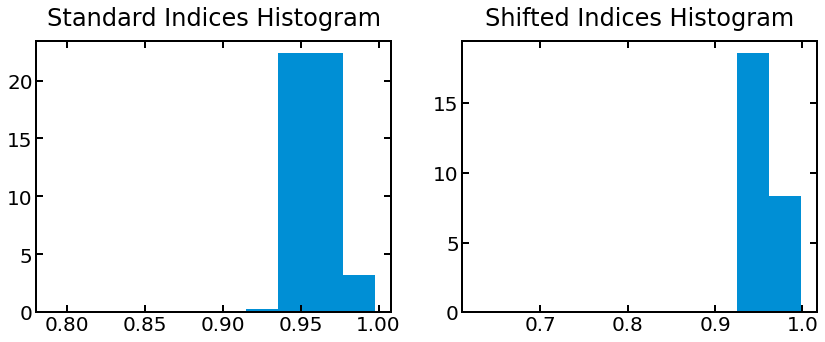

In [349]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.title('Standard Indices Histogram')
plt.hist(all_inds, density=True)
plt.subplot(1, 2, 2)
plt.title('Shifted Indices Histogram')
plt.hist(all_shifted_inds, density=True)
plt.show()

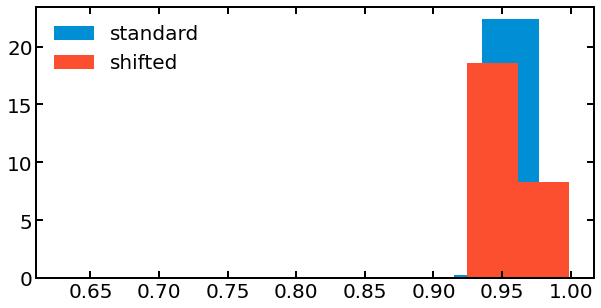

In [351]:
plt.hist(all_inds, density=True, label='standard')
plt.hist(all_shifted_inds, density=True, label='shifted')
plt.legend()
plt.show()

In [352]:
scipy.stats.mannwhitneyu(all_inds, all_shifted_inds, alternative='greater')

MannwhitneyuResult(statistic=2794374.0, pvalue=0.02443219933476429)

In [221]:
shifted_results

,explained_variance,coefs,intercept,eigs,criticality_inds,info_criteria,train_mse,test_mse,persistence_baseline,start_ind,end_ind,start_time,end_time,window,stride,p,T_pred
0,None,"[[[4.945906752710542, 0.0054561817662334006, 0...","[-2.6035727729587505e-05, 7.658897481914029e-0...","[(-0.5105983898627289+0.8008116139606083j), (-...","[0.9497420474974274, 0.9497420474974274, 0.946...","{'aic': -148.53383719077084, 'bic': -146.15031...",3.640252e-07,1.261694e-07,0.000011,0,4000,0,4,4,4,15,25
1,None,"[[[4.9348654272030155, -0.0032374601078408796,...","[-1.6144839423990865e-06, -4.7728467122211666e...","[(-0.4901088062093177+0.8163184236255335j), (-...","[0.9521462128656494, 0.9521462128656494, 0.937...","{'aic': -150.31162133353817, 'bic': -147.92809...",3.021677e-07,4.373656e-07,0.000064,4000,8000,4,8,4,4,15,25
2,None,"[[[4.8742241388079925, 0.016704972544522523, -...","[-5.131839463260843e-06, -1.1264270930848634e-...","[(-0.4963099460788858+0.8094852510017179j), (-...","[0.9495208971719057, 0.9495208971719057, 0.944...","{'aic': -149.65358355204887, 'bic': -147.27005...",3.253201e-07,1.088715e-07,0.000009,8000,12000,8,12,4,4,15,25
3,None,"[[[4.876525324304248, -0.003069292866561546, -...","[9.322099306145199e-06, -2.3253483049962724e-0...","[(-0.4960977028017858+0.7993565313342622j), (-...","[0.9407889215503934, 0.9407889215503934, 0.948...","{'aic': -149.32856041834668, 'bic': -146.94503...",3.410487e-07,2.480815e-07,0.000058,12000,16000,12,16,4,4,15,25
4,None,"[[[5.038190201793552, -0.017494159809319745, 0...","[4.967405062372922e-06, 3.088036216541229e-06,...","[(-0.5036663353083448+0.8024914470435084j), (-...","[0.9474556981204568, 0.9474556981204568, 0.948...","{'aic': -150.47840361388748, 'bic': -148.09487...",3.006600e-07,7.740244e-07,0.000109,16000,20000,16,20,4,4,15,25
5,None,"[[[4.905117809075242, 0.005425312769101215, 0....","[-1.7027728818093159e-06, -1.9956313342597574e...","[(-0.49733203873391835+0.8089091028541492j), (...","[0.9495646862807927, 0.9495646862807927, 0.953...","{'aic': -150.4431161548374, 'bic': -148.059592...",3.057541e-07,2.210237e-07,0.000030,20000,24000,20,24,4,4,15,25
6,None,"[[[4.956936443307108, -0.019212753958533113, 0...","[-5.246378220041011e-06, 8.542159678053248e-06...","[(-0.43615251671450805+0.8471007963404817j), (...","[0.9527899962725667, 0.9527899962725667, 0.949...","{'aic': -149.36214484659382, 'bic': -146.97862...",3.325421e-07,1.845014e-07,0.000023,24000,28000,24,28,4,4,15,25
7,None,"[[[4.957952778457719, -0.023682005418018126, 0...","[-1.921372577319922e-05, -7.356290907683895e-0...","[(-0.506075859800131+0.8100566131036343j), (-0...","[0.9551463198407734, 0.9551463198407734, 0.953...","{'aic': -149.5133879160573, 'bic': -147.129864...",3.230099e-07,2.828751e-07,0.000028,28000,32000,28,32,4,4,15,25
8,None,"[[[4.968178770313264, -0.02341617056759072, 0....","[8.99591492990965e-06, 3.479010468426498e-06, ...","[(-0.4974367351347151+0.7987431629786765j), (-...","[0.9409749974715935, 0.9409749974715935, 0.957...","{'aic': -151.81896779112896, 'bic': -149.43544...",2.607318e-07,2.046998e-07,0.000022,32000,36000,32,36,4,4,15,25
9,None,"[[[4.961624782395503, 0.0258772873244048, -0.0...","[-1.1276456435743407e-06, -5.074867356657522e-...","[(-0.4309412387637598+0.8453437946006086j), (-...","[0.9488500842266916, 0.9488500842266916, 0.949...","{'aic': -149.54231237604728, 'bic': -147.15878...",3.320284e-07,1.675752e-07,0.000018,36000,40000,36,40,4,4,15,25


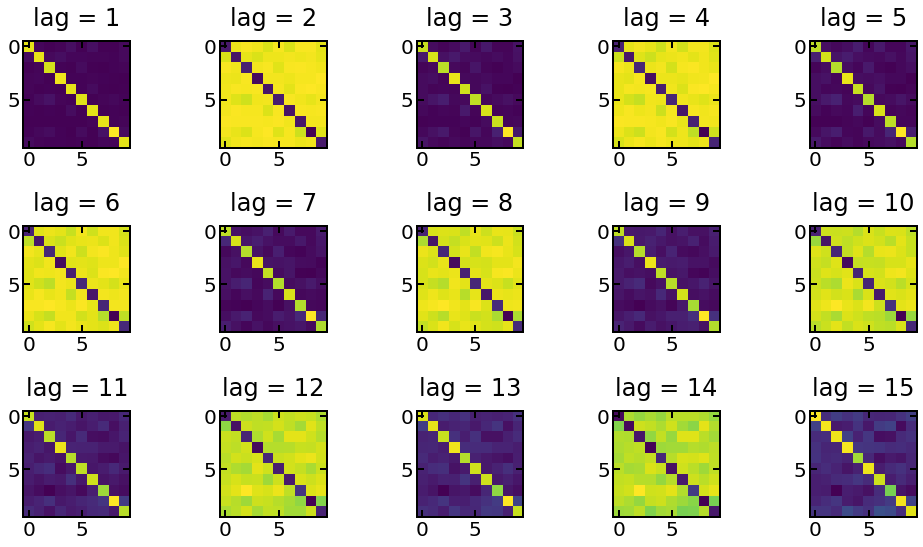

In [287]:
fig, axs = plt.subplots(3, 5, figsize=(14, 8))
for i in range(15):
    ax = axs[int(i/5)][i % 5]
    ax.imshow(standard_results.coefs.iloc[0][i].T)
    ax.set_title(f"lag = {i + 1}")
plt.tight_layout()

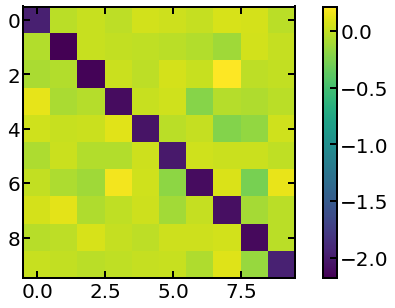

In [281]:
plt.imshow(shifted_results.coefs.iloc[0][i-1])
plt.colorbar()